[View in Colaboratory](https://colab.research.google.com/github/vishal2develop/Kaggle-Competitions/blob/master/TGS_Salt_Identification.ipynb)

**Install Dependencies**

In [10]:
!pip install imageio
!pip install torch
!pip install kaggle

    100% |████████████████████████████████| 3.3MB 9.2MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58a10000 @  0x7f81b70871c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 235kB 5.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - d

**Import Dependencies**

In [0]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch
# In case we need a backup dataset
from torch.utils import data


**Upload the Kaggle credentials**

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishal2develop","key":"3619f8dc52302b60f165373fa53fb3f4"}'}

**Check if it is there**

In [15]:
ls -1ha kaggle.json

kaggle.json


**File Configuration**

In [0]:
# Creating a kaggle dir
!mkdir -p ~/.kaggle
# Copying kaggle,json to kaggle dir
!cp kaggle.json ~/.kaggle/
# Owner can read & write to the file
!chmod 600 ~/.kaggle/kaggle.json

**Download our dataset from** ***KAGGLE***

In [17]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 63.3MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 75.9MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 122MB/s]
 92% 151M/163M [00:00<00:00, 141MB/s]
100% 163M/163M [00:00<00:00, 175MB/s]
 82% 31.0M/37.9M [00:00<00:00, 61.5MB/s]
100% 37.9M/37.9M [00:00<00:00, 77.3MB/s]


**Unzip**

In [18]:
!ls

depths.csv   sample_data	    test.zip   train.zip
kaggle.json  sample_submission.csv  train.csv


In [20]:
!unzip train.zip

Archive:  train.zip
replace images/8d08955cdf.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images/e045664b46.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Create a class to represent the dataset**

In [0]:
class TGSSaltDataset(data.Dataset):
  # Initialize with the location of the dataset and the list of files
  def __init__(self,root_path,file_list):
    self.root_path=root_path
    self.file_list=file_list
    
  # Create two getter methods
  # First - Tells us the no of images we have
  def __len__(self):
    return len(self.file_list)
  
  # Second - #get method - return the seismic image + label for a given index 
  def __getitem__(self,index):
    file_id=self.file_list[index]
    # image folder+path
    image_folder=os.path.join(self.root_path,"images")
    image_path=os.path.join(image_folder,file_id +".png")
    
    # label folder+path
    mask_folder=os.path.join(self.root_path,"masks")
    mask_path=os.path.join(mask_folder,file_id +".png")
    
    #read
    # Converting to binary as U-net accepts only binary forms
    image=np.array(imageio.imread(image_path),dtype=np.uint8)
    mask=np.array(imageio.imread(mask_path),dtype=np.uint8)
    
    return image,mask
  
    
    
    

**Initialize our new class dataset**

In [0]:
#train image+mask data
train_mask=pd.read_csv('train.csv')
#Depth data
depth=pd.read_csv('depths.csv')
#training path
train_path='./'
#List of files
file_list= list(train_mask['id'].values)
#Define our dataset using our calss
dataset=TGSSaltDataset(train_path, file_list)


**Fuction to visualize the images**

In [0]:
def plot2x2array(image,mask):
  #invoke matplotlib
  f, axarr=plt.subplots(1,2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[0].grid()
  axarr[1].grid()
  axarr[0].set_title("Image")
  axarr[1].set_title("Mask")
  
  

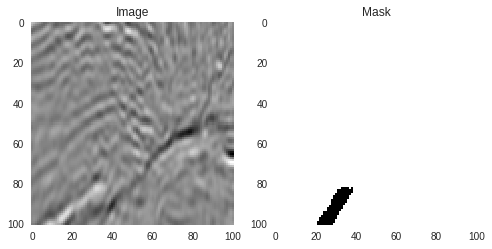

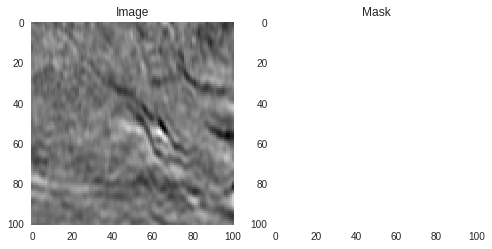

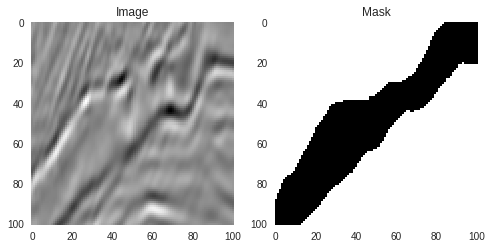

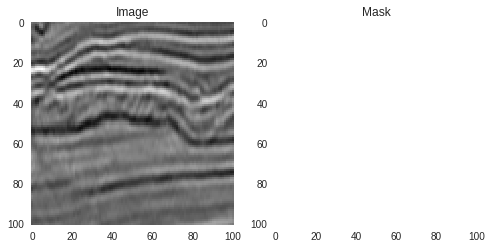

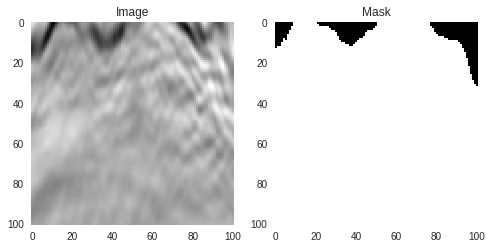

In [24]:
# Print the Images
for i in range(5):
  image, mask=dataset[np.random.randint(0, len(dataset))]
  plot2x2array(image, mask)

Text(0.5,1,'Depth distribution')

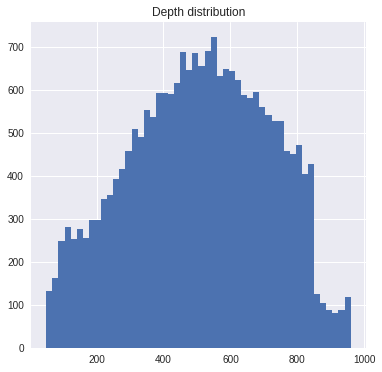

In [25]:
# Plot the distribution of depths
plt.figure(figsize=(6,6))
plt.hist(depth['z'], bins=50)
plt.title("Depth distribution")


Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (that is, sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run.

**Using TensorFlow Backend**

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [28]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

#decoder

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seems to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 8)  584         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

In [6]:
!pip install ipywidgets

    100% |████████████████████████████████| 112kB 3.0MB/s 
    100% |████████████████████████████████| 2.2MB 6.2MB/s 


In [29]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:25<00:00, 158.76it/s]

Done!


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [0]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

**The above code will run until val_loss no longer improves.**